# Link between GitHub repository and ExTRI2 paper
A notebook containing links to, or code for, generating the figures, tables, and results for the ExTRI2 paper, divided by the different sections in the paper.

Go to each section to see the analysis done, or a link to the script/notebook that contains the information.

In [1]:
__import__('sys').path.append('../scripts/common/'); __import__('notebook_utils').table_of_contents('repo_to_paper.ipynb')

<h3>Table of contents</h3>


[Link between GitHub repository and ExTRI2 paper](#Link-between-GitHub-repository-and-ExTRI2-paper)
- [Setup & configuration](#Setup-&-configuration)
- [2.1. Overview of the ExTRI2 pipeline](#2.1.-Overview-of-the-ExTRI2-pipeline)
- [2.2. Data sources and preparation](#2.2.-Data-sources-and-preparation)
  - [2.2.1 Retrieving annotated abstracts from PubTator3](#2.2.1-Retrieving-annotated-abstracts-from-PubTator3)
  - [2.2.2 Retrieving TF Gene IDs from TFCheckpoint and GO annotations](#2.2.2-Retrieving-TF-Gene-IDs-from-TFCheckpoint-and-GO-annotations)
- [2.3 Curated dataset for training – The NTNU collection & 3.1 The NTNU collection](#2.3-Curated-dataset-for-training-–-The-NTNU-collection-&-3.1-The-NTNU-collection)
- [2.4. Classifier configuration and training & 3.4.1. Classifiers performance](#2.4.-Classifier-configuration-and-training-&-3.4.1.-Classifiers-performance)
- [2.5 Improvement of the training dataset](#2.5-Improvement-of-the-training-dataset)
  - [2.5.1 Sentence splitter](#2.5.1-Sentence-splitter)
  - [2.5.2 Iterative classifier training and dataset revision](#2.5.2-Iterative-classifier-training-and-dataset-revision)
- [2.6. Validation criteria and process & 3.3.2. Manual validation outcomes](#2.6.-Validation-criteria-and-process-&-3.3.2.-Manual-validation-outcomes)
- [3.2. The ExTRI2 resource](#3.2.-The-ExTRI2-resource)
- [Supp. File. Post-processing](#Supp.-File.-Post-processing)

## Setup & configuration

In [2]:
# IMPORTS
import pandas as pd
import numpy as np
import os
import json
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import upsetplot
import warnings
from analysis import *


from Bio import Entrez
# *Always* tell NCBI who you are
Entrez.email = "example24@gmail.com"

## Custom functions
import sys

sys.path.append('../scripts/common/')
from notebook_utils import h3, h4, h5, md
from analysis import load_config
pd.set_option('display.max_colwidth', 20)

In [3]:
# LOAD DATA
config = load_config()

# Load ExTRI dataset
ExTRI2_df = pd.read_csv(config['final_ExTRI2_p'], sep="\t", dtype=str, keep_default_na=False)
# Add columns to ExTRI2 df to facilitate analysis
ExTRI2_df['TRI Id']             = ExTRI2_df['TF Id'] + '|' + ExTRI2_df['TG Id']

# Load the validation dataset
validated_df           = pd.read_csv(config['final_validated_p'], sep='\t', header=0, dtype=str)

# Load the supp. file with all TF IDs, and modify TF type
TFs_df = pd.read_csv("tables/all_TFs.tsv", sep="\t", dtype=str)

# Drop validated_df repeated column
assert (validated_df['TF_type_validated'] == validated_df['TF_type']).all(), "The TF types in the validated df have been modified!"
validated_df.drop(columns=['TF_type_validated'], inplace=True)

In [4]:
# CHANGE THE TF TYPE TO THE NEW CATEGORISATION FOR VALIDATED DF & ExTRI2

def modify_TF_type(df, TFs_df):
    '''
    Modify the "TF_type" column of df by the new categorisation present in TFs_df.
    Rows with no TF type are marked as "-" and then removed.
    '''

    # Build the mapping dict
    id_to_type = dict(zip(
        TFs_df['Gene ID'].astype(str),
        TFs_df['updated TF type'].fillna('-').astype(str)
    ))
    # Add NFKB and AP1 complexes
    id_to_type['Complex:NFKB'] = 'dbTF'
    id_to_type['Complex:AP1'] = 'dbTF'

    # Make sure all unclassified genes are marked with "-"
    assert (set(id_to_type.values()) == {'dbTF', 'coTF', 'coTF candidate', '-'}), "Unexpected TF types found in the mapping dict"

    # Function to map IDs
    def map_ids(row):
        return ";".join(
            id_to_type.get(x.strip(), '-')   # use "-" if unknown
            for x in row['TF Id'].split(";")
        )

    df['new_TF_type'] = df.apply(map_ids, axis=1)

    # Show the difference between old and new TF types
    md("Difference between old and new TF types:")
    display(df[['TF_type', 'new_TF_type']].value_counts(dropna=False))

    # Replace old TF_type by new_TF_type
    df.drop(columns=['TF_type'], inplace=True)
    df.rename(columns={'new_TF_type': 'TF_type'}, inplace=True)

    # Remove rows with no TF type (all "-")
    n_before = len(df)
    df = df[df['TF_type'].str.split(";").apply(lambda x: set(x) != {'-'})]
    n_after = len(df)
    md(f"Removed {n_before - n_after} ({(n_before - n_after) / n_before:.2%}) rows with no TF type ({n_before} -> {n_after})")

    return df


# Modify both validated_df & ExTRI2_df to the new categorisation
md("Validated df:")
validated_df = modify_TF_type(validated_df, TFs_df)
md("ExTRI2 df:")
ExTRI2_df = modify_TF_type(ExTRI2_df, TFs_df)

# Save the modified dataframes
validated_df.to_csv(config['paper_ExTRI2_p'], sep="\t", index=False)
ExTRI2_df.to_csv(config['paper_validated_p'], sep="\t", index=False)

# Make the 3 categories ordinal for validated_df
tf_types = ['dbTF', 'coTF', 'coTF candidate']
validated_df['TF_type'] = pd.Categorical(
    validated_df['TF_type'],
    categories=tf_types,
    ordered=True
)

Validated df:

Difference between old and new TF types:

TF_type  new_TF_type   
dbTF     dbTF              3678
ll_coTF  coTF candidate    1392
coTF     coTF candidate    1306
         coTF               652
ll_coTF  coTF                78
coTF     -                   51
dbTF     coTF candidate      47
         -                   39
         coTF                25
ll_coTF  -                   14
coTF     dbTF                 8
Name: count, dtype: int64

Removed 104 (1.43%) rows with no TF type (7290 -> 7186)

ExTRI2 df:

Difference between old and new TF types:

TF_type                  new_TF_type                            
dbTF                     dbTF                                       418476
ll_coTF                  coTF candidate                             200348
coTF                     coTF candidate                             105064
                         coTF                                        81155
ll_coTF;ll_coTF          coTF candidate;coTF candidate                9792
                                                                     ...  
coTF;coTF;coTF;coTF      coTF candidate;coTF;coTF candidate;coTF         1
coTF;coTF;coTF           dbTF;dbTF;coTF candidate                        1
                         coTF;coTF candidate;dbTF                        1
coTF;coTF;-;-;-;-        coTF candidate;-;-;-;-;-                        1
ll_coTF;ll_coTF;ll_coTF  coTF candidate;coTF;coTF candidate              1
Name: count, Length: 149, dtype: int64

Removed 3422 (0.41%) rows with no TF type (835622 -> 832200)

## 2.1. Overview of the ExTRI2 pipeline

Scripts used for the different parts of the pipeline:
1. **Abstracts and Entity Extraction:** See [scripts/preprocessing/README.md](../scripts/preprocessing/README.md) for a description of the different scripts used
2. **Abstract Segmentation and Candidate Sentences Creation:** [workflow.rb](../workflow.rb)
3. **Identification of TRIs and their MoR:** [workflow.rb](../workflow.rb), using classifiers trained with [classifiers_training/run_classifiers.sh](../classifiers_training/run_classifiers.sh)
4. **Post-processing and normalization:** [postprocessing.py](../scripts/postprocessing/postprocessing.py) and [postprocessing_checkings.ipynb](../scripts/postprocessing/postprocessing_checkings.ipynb)

## 2.2. Data sources and preparation

### 2.2.1 Retrieving annotated abstracts from PubTator3
See [get_all_pubtators.sh](../scripts/preprocessing/get_all_pubtators.sh)

### 2.2.2 Retrieving TF Gene IDs from TFCheckpoint and GO annotations
See [get_NCBI_TF_IDs.ipynb](../scripts/preprocessing/get_NCBI_TF_IDs.ipynb)

## 2.3 Curated dataset for training – The NTNU collection & 3.1 The NTNU collection

See [update_tri_sentences.ipynb](../scripts/classifiers_training/update_tri_sentences.ipynb) for details on how the final_NTNU_df was created.

In [5]:
# Original annotated sentences
original_NTNU_df = pd.read_csv('../data/external/original_tri_sentences.tsv', sep='\t', skiprows=1)

# Sentences used for training the models (where suboptimal sentences are "Not TRI")
training_df = pd.read_csv('../classifiers_training/data/tri_sentences.tsv', sep='\t')

# Final NTNU dataset
final_NTNU_df = pd.read_csv('../results/NTNU_dataset.tsv', sep='\t')

def display_NTNU_analysis(original_NTNU_df, final_NTNU_df):
    md("Comparison of original and final NTNU datasets")
    NTNU_analysis = {'Original': {}, 'Final': {}}

    for name, df in [('Original', original_NTNU_df), ('Final', final_NTNU_df)]: 
        NTNU_analysis[name]['Total'] = len(df)
        NTNU_analysis[name]['Unique'] = len(df[['Sentence', 'TF', 'TG']].drop_duplicates())
        NTNU_analysis[name]['Duplicated'] = (df[['Sentence', 'TF', 'TG']].duplicated().sum())


        for TRI in [False, True]:
            NTNU_analysis[name][TRI] = len(df[df['Label'] == TRI])
        for MoR in ['UNDEFINED', 'ACTIVATION', 'REPRESSION']:
            NTNU_analysis[name][MoR] = len(df[df['Type'] == MoR])
            
    NTNU_analysis = pd.DataFrame.from_dict(NTNU_analysis)
    NTNU_analysis['difference'] = NTNU_analysis['Final'] - NTNU_analysis['Original']

    display(NTNU_analysis.map(lambda x: f"{x:,}" if isinstance(x, int) else x))

def analyse_NTNU_normalisation():

    # Get normalised TF & TG columns
    final_NTNU_df['norm TF'] = final_NTNU_df["#TRI ID"].apply(lambda x: x.split(":")[2])
    final_NTNU_df['norm TG'] = final_NTNU_df["#TRI ID"].apply(lambda x: x.split(":")[3])

    md("Number of unique TF and TG in the final NTNU dataset")
    rows = []

    for label in ("TRI", "Not TRI", "Total"):
        for TX in ["TF", "TG"]:   
            # Get subset, if necessary
            subset = final_NTNU_df if label == "Total" else final_NTNU_df[final_NTNU_df['Label'] == label]

            # Extract relevant info
            rows.append({
                "Subset": label,
                "Type": TX,
                "Mention": subset[TX].nunique(),
                "Normalised": subset[f"norm {TX}"].nunique()
            })

    summary_df = pd.DataFrame(rows)
    display(summary_df.pivot(index="Subset", columns="Type", values=["Mention", "Normalised"]))

    # Load all TFs
    all_TFs_df = pd.read_csv('tables/all_TFs.tsv', sep='\t', dtype=str)
    TFs_symbols = set(all_TFs_df['Symbol'].str.upper())

    # Get normalised TFs in the TF list
    normalised_TFs = set(final_NTNU_df['norm TF'].str.upper())
    normalised_TFs_in_TF_list = normalised_TFs.intersection(TFs_symbols)

    md(f"Number of normalised TFs in the TF list: {len(normalised_TFs_in_TF_list)}/{len(normalised_TFs)} ({len(normalised_TFs_in_TF_list)/len(normalised_TFs):.2%})")
    md("Most common TFs outside the TF list:")

    print(len(TFs_symbols), TFs_symbols)
    m = ~final_NTNU_df['norm TF'].str.upper().isin(list(TFs_symbols))
    display(final_NTNU_df[m]['norm TF'].value_counts().head(30))

def save_NTNU_dataset(training_df):
    "Change NTNU dataset so it has the expected format of the paper"
    paper_NTNU = training_df.copy()

    # Rename columns to match the paper format
    paper_NTNU.rename(columns={'Label': 'TRI', 'Type': 'MoR'}, inplace=True)
    paper_NTNU['TRI'] = paper_NTNU['TRI'].replace({False: 'Not TRI', True: 'TRI'})

    # Drop unneeded columns
    paper_NTNU.drop(columns=['validated?', 'Unnamed: 0'], inplace=True)

    # Save into tables
    pd.DataFrame.to_csv(paper_NTNU, "tables/NTNU_dataset.tsv", index=False, header=True, sep='\t')

    display(paper_NTNU.head())

# Show content of the NTNU training set
display_NTNU_analysis(original_NTNU_df, training_df)

# Save into "tables/" in the correct format
save_NTNU_dataset(training_df)

Comparison of original and final NTNU datasets

,Original,Final,difference
Total,"22,135","21,572",-563
Unique,"21,766","21,572",-194
Duplicated,369,0,-369
False,"10,986","10,169",-817
True,"11,149","11,403",254
UNDEFINED,"3,884","4,044",160
ACTIVATION,"5,339","5,344",5
REPRESSION,"1,926","2,015",89


,#TRI ID,Sentence,TF,TG,TRI,MoR
0,16373364:0:Ets1:...,"A role for [TF],...",Ets1,GATA-3,Not TRI,NaN
1,16373364:0:Ets1:...,"A role for [TF],...",Ets1,IL-5,TRI,UNDEFINED
2,16373364:0:Ets1:...,"A role for [TF],...",Ets1,AP-1,Not TRI,NaN
3,16373364:0:GATA-...,"A role for [TG],...",GATA-3,Ets1,Not TRI,NaN
4,16373364:0:GATA-...,"A role for Ets1,...",GATA-3,IL-5,TRI,UNDEFINED


## 2.4. Classifier configuration and training & 3.4.1. Classifiers performance

**2.4**<br>
Facts stated in the text
* Train-test split is 85:15 - [src/dataset.py](../classifiers_training/src/dataset.py)
* **Table S3:** Values obtained from [classifiers_comparison.ipynb/Final iteration](classifiers_comparison.ipynb)
* **Table S4 and Table S5:** Values obtained from [classifiers_comparison.ipynb/Previous iterations](classifiers_comparison.ipynb)

**3.4.1.**<br>
Final models F1 score on test dataset: 0.94 for TRI and 0.95 for MoR. Obtained from [classifiers_comparison.ipynb/Final models](classifiers_comparison.ipynb). There is also a confusion matrix there.

## 2.5 Improvement of the training dataset

### 2.5.1 Sentence splitter
From [update_tri_sentences.ipynb#Modify_joined_sentences](../scripts/classifiers_training/update_tri_sentences.ipynb) we extract the claim that "sciSpacy detected 54 sentences (0.25% of the dataset) that required further splitting. They were discarded"

### 2.5.2 Iterative classifier training and dataset revision
**Facts stated in the text:**
* We revised **3111 sentences** (14.4% of the dataset) ([prepare_reannotation_Excels.ipynb#Compare original and revised datasets](../scripts/classifiers_training/prepare_reannotation_Excels.ipynb)):
  *  3086 from the original NTNU dataset plus 25 extra negative sentences. We modified the label in **1991** of those sentences [update_tri_sentences.ipynb#Reannotations](../scripts/classifiers_training/update_tri_sentences.ipynb)

Figures and tables:
* **Figure 5** made in [prepare_reannotation_Excels.ipynb#Compare original and revised datasets](../scripts/classifiers_training/prepare_reannotation_Excels.ipynb)
* **Table 6** can partly be found in [prepare_reannotation_Excels.ipynb#Compare original and revised datasets](../scripts/classifiers_training/prepare_reannotation_Excels.ipynb) but standard deviation and MoR classifiers data is obtained from [classifiers_comparison.ipynb](classifiers_comparison.ipynb)
* **Table S11** in [prepare_reannotation_Excels.ipynb#Comparison of the worst predicted sentences (threshold=0.2) between the different iterations](../scripts/classifiers_training/prepare_reannotation_Excels.ipynb)

## 2.6. Validation criteria and process & 3.3.2. Manual validation outcomes

In [6]:
# Save validated_df in the format specified in the paper
def save_paper_validated_df(validated_df):
    '''Get the validated_df in the format specified in the paper'''

    # Only keep relevant columns
    columns = ['#SentenceID', 'Sentence', 'Label', 'MoR', 'Valid?', 'true_label', 'true_MoR', 'Valid score', 'MoR scores',  # TRI - MoR validation
               'TF', 'TF Id', 'TF Symbol', 'TF TaxID',  'TF_is_incorrect', 'TF_correct_mention', 'TF offset',               # TF validation
               'TG',  'TG Id', 'TG Symbol', 'TG TaxID', 'TG_is_incorrect', 'TG_correct_mention', 'Gene offset',             # TG validaiton
               'method', 'stage', 'renormalisation', 'pre-post', 'TF_type',                                                 # Metadata
               'Other issues', 'Explanation'
               ]
    
    # Only keep relevant columns
    paper_val_df = validated_df[columns].copy()

    # Change column names to match with paper
    paper_val_df.rename(columns={'Label': 'TRI', 'true_label': 'true_TRI', 'Valid score': 'TRI score'}, inplace=True)

    # Change TRI labels to match with paper
    paper_val_df['TRI'] = paper_val_df['TRI'].replace({'FALSE': 'Not TRI', 'TRUE': 'TRI'})
    paper_val_df['true_TRI'] = paper_val_df['true_TRI'].replace({'FALSE': 'Not TRI', 'TRUE': 'TRI'})    
    
    # Save into "tables/" folder
    pd.DataFrame.to_csv(paper_val_df, "tables/all_validated_sentences.tsv", sep='\t', index=False, header=True)

    display(paper_val_df.head())
    
    return

save_paper_validated_df(validated_df)

,#SentenceID,Sentence,TRI,MoR,Valid?,true_TRI,true_MoR,TRI score,MoR scores,TF,...,TG_is_incorrect,TG_correct_mention,Gene offset,method,stage,renormalisation,pre-post,TF_type,Other issues,Explanation
0,10490613:2:NF-ka...,A hallmark of in...,TRI,ACTIVATION,F,Not TRI,NaN,NaN,0.00833613522600...,NF-kappaB.,...,NaN,NaN,538,random,s1,NFKB,pre,dbTF,Splitter,NaN
1,34564314:2:TP53:...,Long non-coding ...,TRI,UNDEFINED,T,TRI,UNDEFINED,NaN,0.99718615402933...,TP53,...,NaN,NaN,160,random,s1,NaN,pre,dbTF,NaN,NaN
2,33916908:6:NRF2:EGF,ChIP sequencing ...,TRI,UNDEFINED,T,TRI,UNDEFINED,NaN,0.99766902869249...,NRF2,...,NaN,NaN,876,random,s1,NaN,pre,dbTF,NaN,NaN
3,33766982:4:Camta...,"In this study, w...",TRI,UNDEFINED,F,Not TRI,NaN,NaN,0.99678953469570...,Camta1,...,NaN,NaN,479,random,s1,NaN,pre,coTF,NaN,NaN
4,32972752:0:SETDB...,Knockout of [TF]...,TRI,REPRESSION,F,TRI,UNDEFINED,NaN,0.01346601239389...,SETDB1,...,NaN,NaN,129,random,s1,NaN,pre,dbTF,mutation,NaN


TF distribution for the three TF types for the random and balanced datasets (pre post-processing rules)

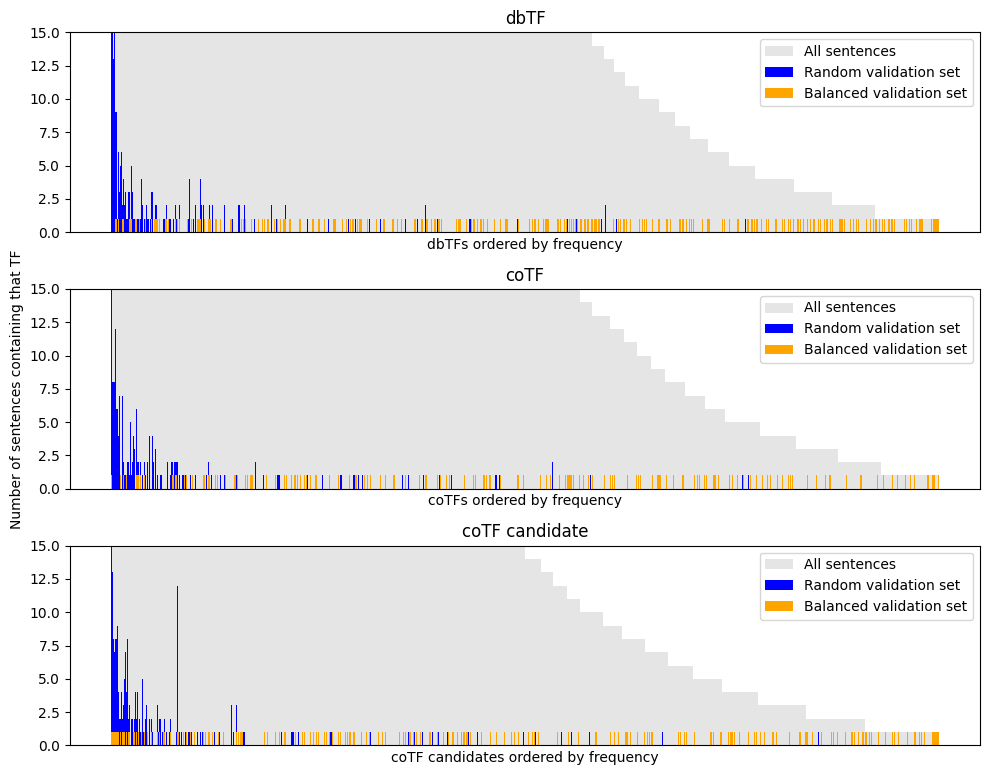

TF distribution for the three TF types for the random and balanced datasets (post post-processing rules)

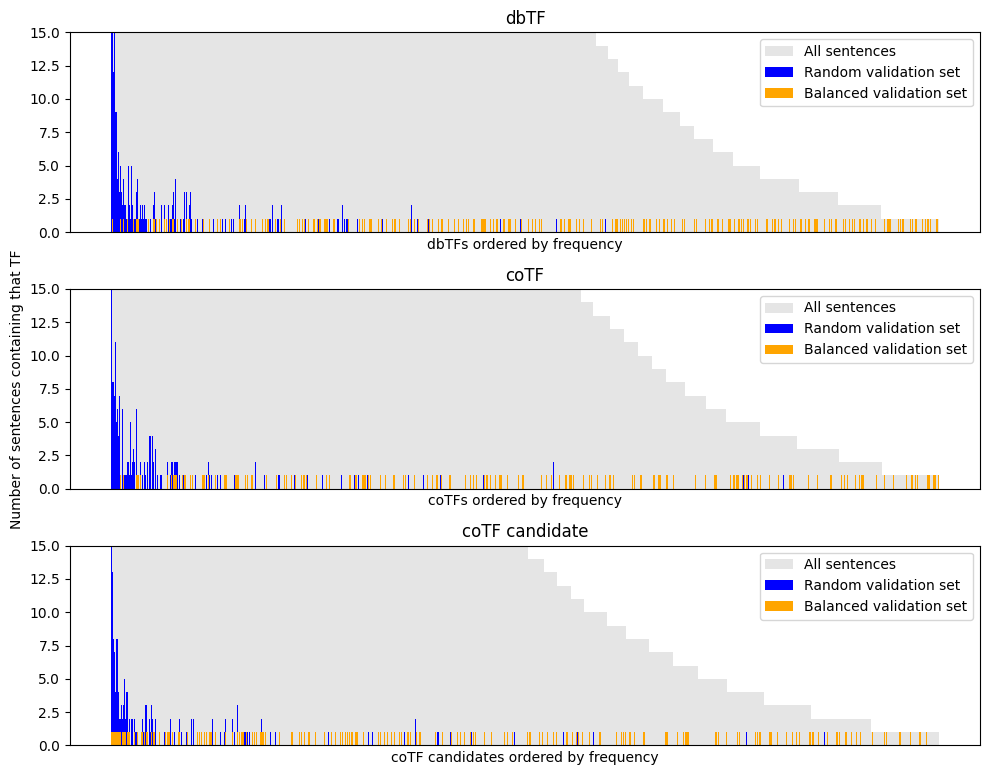

In [7]:
# PLOT - Ensure correctly balanced validation dataset
def plot_tf_validation_distribution(ax, tf_type: str, all_sents: pd.DataFrame, val_random: pd.DataFrame, val_balanced: pd.DataFrame, ylim=30):
    for df, label, color, alpha in [
        (all_sents, "All sentences", "grey", 0.2),
        (val_random, "Random validation set", "blue", 1),
        (val_balanced, 'Balanced validation set', "orange", 1)
    ]:
        counts = df['TF Id'].value_counts()
        ax.bar(counts.index, counts, label=label, color=color, alpha=alpha, width=1)
    ax.set_title(tf_type)
    ax.set_xticks([])
    #plt.xticks(rotation='vertical')
    ax.set_xlabel(f"{tf_type}s ordered by frequency")
    ax.set_ylim((0,ylim))
    ax.legend()

def plot_all_tf_validation_distributions(title, ExTRI2_df, validated_1mapping, figsize=(15, 10), ylim=30):

    fig, axes = plt.subplots(3, 1, figsize=figsize)
    for i, TF_type in enumerate(validated_1mapping['TF_type'].cat.categories):
        TRI_subset = ExTRI2_df[ExTRI2_df['TF_type'] == TF_type]
        validated_subset = validated_1mapping[(validated_1mapping['TF_type'] == TF_type)]

        validated_subset_b = validated_subset[validated_subset['method'] == 'balanced']
        validated_subset_r = validated_subset[validated_subset['method'] == 'random']

        plot_tf_validation_distribution(axes[i], TF_type, TRI_subset, val_balanced = validated_subset_b, val_random = validated_subset_r, ylim=ylim)
    axes[1].set_ylabel(f"Number of sentences containing that TF")

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

for pre_post in ["pre", "post"]:
    md(f"TF distribution for the three TF types for the random and balanced datasets ({pre_post} post-processing rules)")
    plot_all_tf_validation_distributions("", ExTRI2_df, validated_df[(validated_df['pre-post'] == pre_post) & (validated_df['Label'] == 'TRUE')], figsize=(10, 8), ylim = 15)

In [8]:
def evaluate_other_issues(validated_df):
    h3("Other issues")

    # Get sentences where there are other issues
    o_i = validated_df.drop_duplicates(subset=['#SentenceID'], keep='first').dropna(subset=['Other issues'])

    # Display common issues
    display(o_i['Other issues'].apply(lambda x: x.split(';')).explode().value_counts())

    # Get uniquely validated sentences
    validated_unique = validated_df.drop_duplicates(subset=['#SentenceID'], keep='first')

    # Splitter / suboptimal / dir-gene issues
    m = validated_unique['Other issues'].fillna('').str.contains('Splitter')
    print(f"{m.sum()}/{len(m)} ({m.sum()/len(m):.1%}) sentences are incorrecty splitted")
    m = validated_unique['Other issues'].fillna('').str.contains('suboptimal')
    print(f"{m.sum()}/{len(m)} ({m.sum()/len(m):.1%}) sentences are suboptimal")
    m = validated_unique['dir-*'].fillna('') == 'dir-gene'
    print(f"{m.sum()}/{len(m)} ({m.sum()/len(m):.1%}) sentences classified as 'dir-gene")

    # Check for more common issues, what proportion of the dataset do they appear in
    results = []
    for tf_type in validated_df['TF_type'].cat.categories:
        for method in ['random', 'balanced']:
            for p in ['pre', 'post']:
                for validity in ['T', 'F']:

                    df = validated_df[(validated_df['TF_type'] == tf_type) & (validated_df['method'] == method) & (validated_df['pre-post'] == p) & (validated_df['Label'] == 'TRUE') & (validated_df['Valid?'] == validity)]
                    
                    r = {
                        'tf_type': tf_type,
                        'Valid?': validity,
                        'method': method,
                        'pre-post': p,
                        'num_sents': str(len(df))
                    }

                    for issue in ['mutation', 'PPI', 'negation']:
                        m = df['Other issues'].fillna('').str.contains(issue)
                        r[issue] = len(df[m]) / len(df) if m.sum() > 0 else 0
            
                    results.append(r)
    
    index_cols = ['tf_type', 'Valid?', 'method', 'pre-post']
    return pd.DataFrame(results).sort_values(by=index_cols).set_index(index_cols)
  
def display_o_i_joined_pre_post(o_i_results, tf_types):

    index = ['tf_type', 'Valid?', 'method']
    # Pivot pre-post from row index to column index
    o_i_pivot = o_i_results.reset_index().pivot_table(
        index=index,
        columns='pre-post',
        values=['num_sents', 'mutation', 'PPI', 'negation'],
        aggfunc= lambda x: x#f"{x:.2%}" if isinstance(x, float) else str(x)
    )

    # Convert all values to strings for easier handling
    for col in ['mutation', 'PPI', 'negation']:
        o_i_pivot[col] = o_i_pivot[col].map(lambda x: f"{x:.1%}" if isinstance(x, (float)) else str(x))

    # Combine pre and post columns for each metric
    for col in ['mutation', 'PPI', 'negation', 'num_sents']:
        o_i_pivot[(col, 'pre-post')] = (
            o_i_pivot[(col, 'pre')].astype(str) + ' - ' + o_i_pivot[(col, 'post')].astype(str)
        )

    # Filter unnecessary columns
    o_i_pivot = o_i_pivot.filter(like='pre-post')

    # Drop pre-post level
    o_i_pivot.columns = o_i_pivot.columns.droplevel(level=1)

    # Sort tf_type in their categorical order
    o_i_pivot = o_i_pivot.reset_index()
    o_i_pivot['tf_type'] = pd.Categorical(
        o_i_pivot['tf_type'], categories=tf_types, ordered=True
    )
    o_i_pivot = o_i_pivot.sort_values(by=index).set_index(index)


    h3('Other issues, pre-post')
    display(o_i_pivot)

o_i_results = evaluate_other_issues(validated_df)
display_o_i_joined_pre_post(o_i_results, tf_types)

<h3>Other issues</h3>

Other issues
mutation      779
PPI           362
Splitter       52
negation       36
suboptimal      5
Name: count, dtype: int64

52/3905 (1.3%) sentences are incorrecty splitted
5/3905 (0.1%) sentences are suboptimal
1/3905 (0.0%) sentences classified as 'dir-gene


<h3>Other issues, pre-post</h3>

mutation            PPI     negation  \
tf_type        Valid? method                                                
dbTF           F      balanced    6.8% - 8.3%  18.6% - 24.2%  0.6% - 1.7%   
                      random    18.7% - 19.2%    5.8% - 4.8%  2.2% - 2.4%   
               T      balanced  24.0% - 21.4%    0.0% - 0.0%  1.4% - 0.9%   
                      random    30.8% - 30.7%    0.0% - 0.0%  1.6% - 1.6%   
coTF           F      balanced    0.0% - 0.0%  51.9% - 58.9%  0.0% - 0.0%   
                      random      6.9% - 8.3%  43.1% - 52.1%  0.0% - 0.0%   
               T      balanced  38.9% - 33.7%    0.0% - 0.0%  1.1% - 0.0%   
                      random    39.2% - 39.0%    0.0% - 0.0%  0.0% - 0.0%   
coTF candidate F      balanced    1.7% - 1.9%  43.8% - 50.5%  0.0% - 0.9%   
                      random      2.7% - 3.3%  45.5% - 53.5%  0.3% - 0.4%   
               T      balanced  40.3% - 36.8%    0.0% - 0.0%  1.2% - 1.4%   
                      random    40.7% - 40.4%    0.0% - 0.0%  1.7% - 1.8%   

                                num_sents  
tf_type        Valid? method               
dbTF           F      balanced  161 - 120  
                      random    139 - 125  
               T      balanced  658 - 682  
                      random    760 - 755  
coTF           F      balanced    54 - 56  
                      random      58 - 48  
               T      balanced    90 - 98  
                      random    143 - 141  
coTF candidate F      balanced  240 - 214  
                      random    332 - 273  
               T      balanced  330 - 348  
                      random    408 - 396

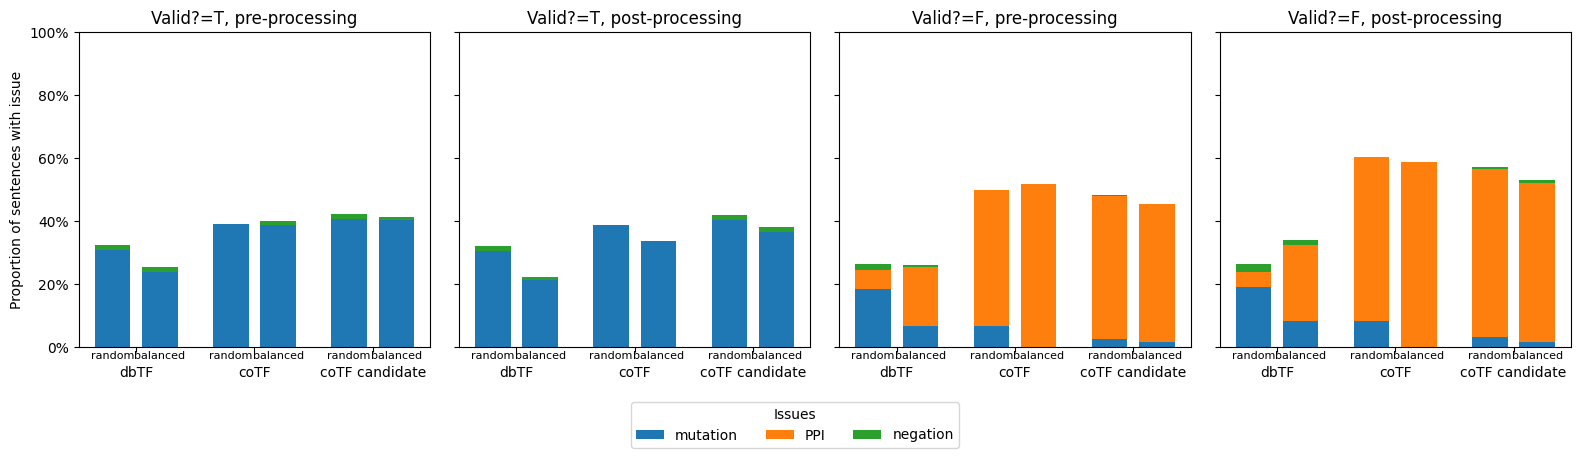

In [9]:
def plot_other_issues_by_combination(o_i_results, tf_types, figsize=(14, 4)):
    # Reset the index to use the index columns as regular columns
    o_i_results_reset = o_i_results.reset_index()

    # Define issues and tf_types
    issues = ['mutation', 'PPI', 'negation']
    hue = 'method'  # Random/Balanced will be the hue
    hue_levels = ['random', 'balanced']  # Ensure this order
    bar_width = 0.2
    group_width = bar_width * len(hue_levels) + 0.1
    withingroup_space = 0.05

    # Define combinations of Valid? and pre-post
    combinations = [
        {'Valid?': 'T', 'pre-post': 'pre'},
        {'Valid?': 'T', 'pre-post': 'post'},
        {'Valid?': 'F', 'pre-post': 'pre'},
        {'Valid?': 'F', 'pre-post': 'post'},
    ]

    # Create a plot for each combination
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 4), sharey=True)
    # axes = axes.flatten()

    for i, (ax, combination) in enumerate(zip(axes, combinations)):
        # Filter data for the current combination
        filtered = o_i_results_reset[
            (o_i_results_reset['Valid?'] == combination['Valid?']) &
            (o_i_results_reset['pre-post'] == combination['pre-post'])
        ]

        # Group data by tf_type and method
        grouped = filtered.groupby(['tf_type', hue])[issues].mean().reset_index()

        # Ensure tf_types and hue levels are consistent
        grouped['tf_type'] = pd.Categorical(grouped['tf_type'], categories=tf_types, ordered=True)
        grouped[hue] = pd.Categorical(grouped[hue], categories=hue_levels, ordered=True)
        grouped = grouped.sort_values(['tf_type', hue])

        # Set bar positions
        x = np.arange(len(tf_types)) * group_width

        # Plot stacked bars for each hue level
        for j, level in enumerate(hue_levels):
            level_data = grouped[grouped[hue] == level]

            # Initialize bottom values
            bottom = np.zeros(len(tf_types))

            # Plot each issue as a stacked segment
            for k, issue in enumerate(issues):
                ax.bar(
                    x + j * bar_width,  # Offset bars within the group
                    level_data[issue],
                    width=bar_width - withingroup_space,
                    bottom=bottom,
                    label=issue if j == 0 else "",
                    color=f'C{k}'
                )
                bottom += level_data[issue]

        # Add TF type labels below the bars
        ax.set_xticks(x + (bar_width * len(hue_levels) / 2) - bar_width / 2)
        ax.set_xticklabels(['' for _ in tf_types])  # Temporarily blank x-ticks

        # ax.set_xticklabels(tf_types)
        ax.set_title(f"Valid?={combination['Valid?']}, {combination['pre-post']}-processing")

        # # Add individual hue labels below each bar and move TF type labels further down
        ax.set_xticks(x + (bar_width * len(hue_levels) / 2) - bar_width / 2)  # Center the group


        # Add individual bar labels for the method
        for j, level in enumerate(hue_levels):
            for idx, tf_type in enumerate(tf_types):
                ax.text(
                    x[idx] + j * bar_width,  # Position based on the bar
                    -0.01,  # Move further down
                    f"{level}", ha="center", va="top", fontsize=8, rotation=0
                )

        # Add TF type labels below the hue labels
        for idx, tf_type in enumerate(tf_types):
            ax.text(
                x[idx] + (bar_width * (len(hue_levels) - 1) / 2),  # Center the label below the group
                -0.06,  # Move further down
                f"{tf_type}", ha="center", va="top", fontsize=10,
            )

        # Format the axes
        ax.set_ylim(0, 1)
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))

        if i == 0:
            ax.set_ylabel('Proportion of sentences with issue')

    # Add a single legend
    fig.legend(
        labels=issues, loc='lower center', ncol=len(issues), title="Issues",
        bbox_to_anchor=(0.5, -0.15), fontsize=10
    )

    # Adjust layout
    plt.tight_layout()
    plt.show()

plot_other_issues_by_combination(o_i_results, tf_types)

In [10]:
# RESULTS
def TRI_validation_results_table(validated_df):
    '''Make table with validation results. Only include TRUE labels'''

    # Only consider TRUE labels
    validated_df_true = validated_df[validated_df['Label'] == 'TRUE']

    results = []
    for tf_type in validated_df['TF_type'].cat.categories:
        for method in ['random', 'balanced']:
            for p in ['pre', 'post']:
                df = validated_df_true[(validated_df_true['TF_type'] == tf_type) & (validated_df_true['method'] == method) & (validated_df_true['pre-post'] == p)]
                
                r = {
                    'tf_type': tf_type,
                    'method': method,
                    'validation stage': p,
                    'num_sents': len(df)
                }

                # Get number of sentences with correct TRIs
                m_T_TRI_df = df['true_label'] == 'TRUE'
                r['Num correct TRIs'] = m_T_TRI_df.sum()

                # Get NER & norm stats
                r['NER'] = 1 - sum(((df[f'{T}_is_incorrect'].str.contains('NER')).sum() for T in ['TF', 'TG'])) / r['num_sents']
                r['NER-TF'] = 1 - (df[f'TF_is_incorrect'].str.contains('NER')).sum() / r['num_sents']
                r['NER-TG'] = 1 - (df[f'TG_is_incorrect'].str.contains('NER')).sum() / r['num_sents']

                r['norm'] = 1 - sum(((df[f'{T}_is_incorrect'].str.contains('norm')).sum() for T in ['TF', 'TG'])) / r['num_sents']
                r['norm-TF'] = 1 - (df[f'TF_is_incorrect'].str.contains('norm')).sum() / r['num_sents']
                r['norm-TG'] = 1 - (df[f'TG_is_incorrect'].str.contains('norm')).sum() / r['num_sents']

                # Get TRI stats
                r['TRI'] = 1 - (df['Label'] != df['true_label']).sum() / r['num_sents']

                # Get MoR stats - over those whose true_label is True
                # (1) Correctly labelled / all sentences
                MoR_df = df[m_T_TRI_df]
                r['MoR'] = len(MoR_df[(MoR_df['MoR'] == MoR_df['true_MoR'])]) / len(MoR_df)

                # Get final probability                
                r['Overall']  = ((df['Valid?'] == 'T') & df[f'TF_is_incorrect'].isna() & df[f'TG_is_incorrect'].isna() ).sum() / r['num_sents']

                # Get the breakdown of MoR labels
                # Precision: Correctly labelled / Sentences classified to that label
                for MoR in ['ACTIVATION', 'REPRESSION', 'UNDEFINED']:
                    r[MoR.capitalize()+" Precision"] = len(MoR_df[(MoR_df['MoR'] == MoR) & (MoR_df['MoR'] == MoR_df['true_MoR'])]) / len(MoR_df[(MoR_df['MoR'] == MoR)])
                
                # Recall: Correctly labelled / Sentences with that as the true label
                for MoR in ['ACTIVATION', 'REPRESSION', 'UNDEFINED']:
                    r[MoR.capitalize()+" Recall"] = len(MoR_df[(MoR_df['MoR'] == MoR) & (MoR_df['MoR'] == MoR_df['true_MoR'])]) / len(MoR_df[(MoR_df['true_MoR'] == MoR)])


                # Ensure num_sents is not treated as a float in the printed table
                r['num_sents'] = str(r['num_sents'])
                r['Num correct TRIs'] = str(r['Num correct TRIs'])

                results.append(r)
   

    return pd.DataFrame(results).set_index(['tf_type', 'method', 'validation stage']).T

def nonTRI_validation_results_table(validated_df):
    '''Make table with validation results. Only include random, post-processed results'''

    validated_df = validated_df[(validated_df['method'] == 'random') & (validated_df['pre-post'] == 'post')]

    results = []
    for tf_type in validated_df['TF_type'].cat.categories:
        df = validated_df[(validated_df['TF_type'] == tf_type)]
        
        r = {'tf_type': tf_type}

        for label, state in (['TRUE', 'TRI'], ['FALSE', 'not TRI']):
            total_num = len(df[df['Label'] == label])
            num_valid = len(df[(df['Label'] == label) & (df['Label'] == df['true_label'])])

            r[state] = f"{num_valid}/{total_num} ({num_valid / total_num:.2%})"

        results.append(r)
   

    return pd.DataFrame(results).set_index(['tf_type']).T

def show_general_statistics(validated_df):
    validated_unique = validated_df.drop_duplicates(subset=['#SentenceID'], keep='first')

    r = {}
    r['Total'] = {
        "Num validated sentences": len(validated_unique),
        "Num TRI validated sentences": len(validated_unique[validated_unique['Label'] == 'TRUE']),
        "Num Not TRI validated sentences": len(validated_unique[validated_unique['Label'] == 'FALSE']),
    }

    for TF in validated_df['TF_type'].cat.categories:
        r[TF] = {
            "Num validated sentences": len(validated_unique[validated_unique['TF_type'] == TF]),
            "Num TRI validated sentences": len(validated_unique[(validated_unique['TF_type'] == TF) & (validated_unique['Label'] == 'TRUE')]),
            "Num Not TRI validated sentences": len(validated_unique[(validated_unique['TF_type'] == TF) & (validated_unique['Label'] == 'FALSE')]),
        }

    display(pd.DataFrame(r))

    return

show_general_statistics(validated_df)

pd.set_option("display.float_format", "{:.1%}".format)

for results_table_f in (TRI_validation_results_table, nonTRI_validation_results_table):
    results_table = results_table_f(validated_df)
    h3(results_table_f.__name__)
    display(results_table)
    results_table.to_csv(f'tables/{results_table_f.__name__}.tsv', sep='\t')

,Total,dbTF,coTF,coTF candidate
Num validated sentences,3905,2003,422,1480
Num TRI validated sentences,3348,1717,355,1276
Num Not TRI validated sentences,557,286,67,204


<h3>TRI_validation_results_table</h3>

tf_type                dbTF                        coTF                  \
method               random       balanced       random        balanced   
validation stage        pre  post      pre  post    pre   post      pre   
num_sents               899   880      819   802    201    189      144   
Num correct TRIs        836   828      686   714    148    146       92   
NER                   98.4% 98.8%    97.4% 98.3%  99.0%  98.9%    95.1%   
NER-TF                99.1% 99.4%    98.0% 98.8%  99.0%  98.9%    95.8%   
NER-TG                99.3% 99.3%    99.4% 99.5% 100.0% 100.0%    99.3%   
norm                  95.1% 96.1%    94.3% 95.8%  98.5%  98.4%    92.4%   
norm-TF               98.8% 99.0%    96.6% 97.6%  99.0%  98.9%    93.8%   
norm-TG               96.3% 97.2%    97.7% 98.1%  99.5%  99.5%    98.6%   
TRI                   93.0% 94.1%    83.8% 89.0%  73.6%  77.2%    63.9%   
MoR                   90.9% 91.2%    95.9% 95.5%  96.6%  96.6%    97.8%   
Overall               79.9% 82.0%    76.4% 82.3%  71.1%  74.6%    62.5%   
Activation Precision  92.4% 92.6%    97.3% 97.3%  98.6%  98.6%   100.0%   
Repression Precision  83.6% 84.4%    91.1% 89.6%  93.0%  93.0%    95.7%   
Undefined Precision   94.0% 93.9%    98.3% 98.2%  97.0%  96.9%    96.0%   
Activation Recall     92.6% 92.8%    95.2% 95.0%  97.3%  97.2%   100.0%   
Repression Recall     92.7% 93.3%    97.7% 97.7% 100.0% 100.0%    95.7%   
Undefined Recall      87.0% 87.1%    95.4% 94.5%  91.4%  91.2%    96.0%   

tf_type                     coTF candidate                        
method                              random        balanced        
validation stage       post            pre   post      pre  post  
num_sents               154            740    669      570   562  
Num correct TRIs         99            423    411      340   361  
NER                   96.1%          97.4%  98.8%    98.1% 98.0%  
NER-TF                96.1%          97.6%  99.0%    98.4% 98.6%  
NER-TG               100.0%          99.9%  99.9%    99.6% 99.5%  
norm                  92.9%          95.7%  97.6%    95.3% 96.1%  
norm-TF               92.9%          97.0%  98.7%    97.2% 97.3%  
norm-TG              100.0%          98.6%  99.0%    98.1% 98.8%  
TRI                   64.3%          57.2%  61.4%    59.6% 64.2%  
MoR                   99.0%          96.5%  96.4%    97.1% 96.4%  
Overall               61.7%          53.2%  57.8%    55.8% 60.1%  
Activation Precision 100.0%          96.2%  96.1%    97.0% 96.5%  
Repression Precision 100.0%          94.7%  94.6%    95.6% 94.8%  
Undefined Precision   96.4%         100.0% 100.0%    98.8% 97.8%  
Activation Recall    100.0%          97.2%  97.1%    98.2% 97.6%  
Repression Recall     96.2%          94.7%  94.6%    94.5% 93.9%  
Undefined Recall     100.0%          97.5%  97.4%    97.6% 96.8%

<h3>nonTRI_validation_results_table</h3>

tf_type,dbTF,coTF,coTF candidate
TRI,828/880 (94.09%),146/189 (77.25%),411/669 (61.43%)
not TRI,284/286 (99.30%),67/67 (100.00%),204/204 (100.00%)


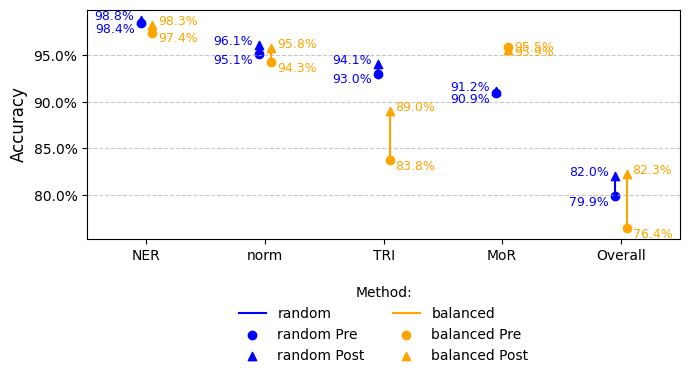

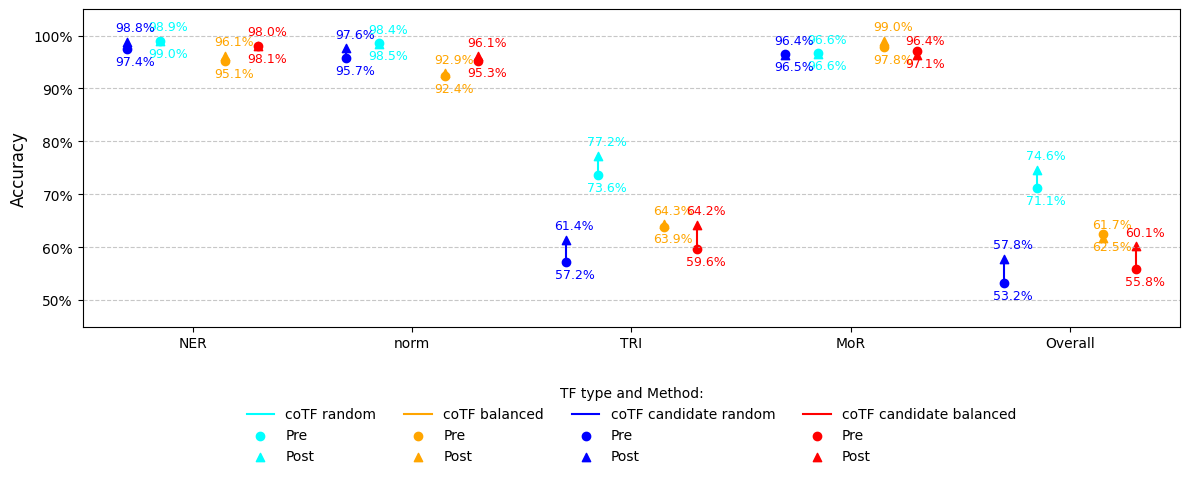

In [ ]:
def make_validation_dotplot(results_table, TF_type = 'dbTF', y_sep = 0):

    XXTF_results_table = results_table[results_table['tf_type'] == TF_type]

    # Create the improved dot plot
    fig, ax = plt.subplots(figsize=(7, 4))

    cols = ['NER', 'norm', 'TRI', 'MoR', 'Overall']
    for i, col in enumerate(cols):

        # Add vertical lines for random and balanced
        for method, sep, color, orientation in [('random', -0.05, 'blue', 'right'), ('balanced', 0.05, 'orange', 'left')]: 

            # Get values for random and balanced for pre and post
            values = {}
            for pre_post in ['pre', 'post']:
                values[pre_post] = XXTF_results_table[(XXTF_results_table['method'] == method) & (XXTF_results_table['validation stage'] == pre_post)][col].values[0]

            ax.plot([i + sep, i + sep], [values['pre'], values['post']], color=color, label=method if i == 0 else "")
            ax.scatter([i + sep], [values['pre']], color=color, marker='o', label=f'{method} Pre' if i == 0 else "")
            ax.scatter([i + sep], [values['post']], color=color, marker='^', label=f'{method} Post' if i == 0 else "")

            # Add value labels next to the dots
            ax.text(i + sep*2, values['pre']-0.01-y_sep, f"{values['pre']:.1%}", fontsize=9, color=color, ha=orientation)
            ax.text(i + sep*2, values['post']+y_sep, f"{values['post']:.1%}", fontsize=9, color=color, ha=orientation)

    # Customize plot appearance
    ax.set_xticks(range(len(cols)))
    ax.set_xticklabels(cols)
    ax.set_ylabel('Accuracy', fontsize=12)
    ax.set_xlim(-0.5, len(cols) - 0.5)
    # ax.set_ylim(0.7, 1.0)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    # ax.set_title('Pre- and Post-Processing Accuracy: Random vs Balanced Sampling', fontsize=14)
    ax.legend(title='Method:', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2, fontsize=10, frameon=False)

    # Add gridlines for readability
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

def make_coTF_validation_dotplot(results_table, y_sep = 0.03):

    # Create the improved dot plot
    fig, ax = plt.subplots(figsize=(12, 5))

    cols = ['NER','norm',  'TRI', 'MoR', 'Overall']

    for TF_type, x_sep in [('coTF', 0.15), ('coTF candidate', 0.3)]:

        XXTF_results_table = results_table[results_table['tf_type'] == TF_type]

        for i, col in enumerate(cols):

            # Add vertical lines for random and balanced
            for method, sep, orientation in [('random', -x_sep, 'right'), ('balanced', x_sep, 'left')]: 

                if TF_type == 'coTF':
                    color = 'aqua' if method == 'random' else 'orange'
                else:
                    color = 'blue' if method == 'random' else 'red'

                # Get values for random and balanced for pre and post
                values = {}
                for pre_post in ['pre', 'post']:
                    values[pre_post] = XXTF_results_table[(XXTF_results_table['method'] == method) & (XXTF_results_table['validation stage'] == pre_post)][col].values[0]

                ax.plot([i + sep, i + sep], [values['pre'], values['post']], color=color, label=f"{TF_type} {method}" if i == 0 else "")
                ax.scatter([i + sep], [values['pre']], color=color, marker='o', label=f'Pre' if i == 0 else "")
                ax.scatter([i + sep], [values['post']], color=color, marker='^', label=f'Post' if i == 0 else "")

                # Add value labels next to the dots
                ax.text(i + sep-0.05, values['pre']  - y_sep, f"{values['pre']:.1%}", fontsize=9, color=color)
                ax.text(i + sep-0.05, values['post'] + y_sep-0.01, f"{values['post']:.1%}", fontsize=9, color=color)

    # Customize plot appearance
    ax.set_xticks(range(len(cols)))
    ax.set_xticklabels(cols)
    ax.set_ylabel('Accuracy', fontsize=12)
    ax.set_xlim(-0.5, len(cols) - 0.5)
    ax.set_ylim(0.45, 1.05)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    # ax.set_title('Pre- and Post-Processing Accuracy: Random vs Balanced Sampling', fontsize=14)
    ax.legend(title='TF type and Method:', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4, fontsize=10, frameon=False)

    # Add gridlines for readability
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

TRI_results_table = TRI_validation_results_table(validated_df).T.reset_index()
make_validation_dotplot(TRI_results_table)
make_coTF_validation_dotplot(TRI_results_table)

## 3.2. The ExTRI2 resource

In [12]:
# Show TF types in ExTRI2
TFs_df[TFs_df['In ExTRI'] == "True"]['updated TF type'].value_counts(dropna=False)

updated TF type
dbTF              2690
coTF candidate    2400
coTF               761
NaN                149
Name: count, dtype: int64

In [13]:
def split_in_dbTF_coTF_coTF_cand(ExTRI2_df):
    m_dbTF = ExTRI2_df['TF_type'].str.contains('dbTF')
    m_coTF = ExTRI2_df['TF_type'].apply(lambda x: 'coTF' in set(x.split(';'))) & ~m_dbTF
    m_coTF_cand = ExTRI2_df['TF_type'].str.contains('coTF candidate') & ~m_dbTF & ~m_coTF

    dbTF_df = ExTRI2_df[m_dbTF]
    coTF_df = ExTRI2_df[m_coTF]
    coTF_cand_df = ExTRI2_df[m_coTF_cand]

    # Check if the split was done correctly
    assert len(ExTRI2_df) == len(dbTF_df) + len(coTF_df) + len(coTF_cand_df)

    return dbTF_df, coTF_df, coTF_cand_df    

dbTF_df, coTF_df, coTF_cand_df = split_in_dbTF_coTF_coTF_cand(ExTRI2_df)

In [14]:
# TABLES 1, 2
def table_1(ExTRI2_df, dbTF_df, coTF_df, coTF_cand_df):

    h3("Table 1")

    analysis_dfs = []
    for df, name in [(ExTRI2_df, 'Total'), (dbTF_df, 'dbTF'), (coTF_df, 'coTF'), (coTF_cand_df, 'coTF candidate')]:

        analytics = {}
        analytics['TRI-sentences'] = f"{len(df):,}"

        for mor in ['UNDEFINED', 'ACTIVATION', 'REPRESSION']:
            analytics[mor] = f"{len(df[df['MoR'] == mor]):,} ({len(df[df['MoR'] == mor])/len(df):.2%})"
        
        analytics['TG is not normalized'] = f"{(df['TG Id'].isna()).sum():,} ({(df['TG Id'].isna()).sum() / len(df):.2%})"
        analytics['Unique TRIs'] = f"{df['TRI Id'].nunique():,}"

        for T in ['TF', 'TG']:
            analytics[f'Unique {T} IDs'] = f"{df[f'{T} Id'].nunique():,}"
            analytics[f'Unique human {T} IDs'] = f"{df[df[f'{T} TaxID'] == '9606'][f'{T} Id'].nunique():,}"

        diff_species_m = df['TF TaxID'].apply(lambda x: set(x.split(';'))) != df['TG TaxID'].apply(lambda x: set(x.split(';')))
        analytics['TF & TG from different species'] = f"{diff_species_m.sum():,} ({diff_species_m.sum() / len(df):.2%})"

        # Convert the analytics dictionary to a DataFrame and add it to the list
        analysis_df = pd.DataFrame.from_dict(analytics, orient='index', columns=[name])
        analysis_dfs.append(analysis_df)

    display(pd.concat(analysis_dfs, axis=1))

def table_2(final_df, dbTF_df):

    # Obtained from other sources
    all_pmids = 38_776_000
    has_gene_entities = 6_507_211

    # Get the number of PMIDs in candidate sentences
    candidate_sents = pd.read_csv(config['raw_ExTRI2_p'], sep='\t', header=1, chunksize=1_000_000, keep_default_na=False)
    candidate_PMIDs = set()
    for chunk in candidate_sents:
        PMIDs = chunk['#SentenceID'].apply(lambda row: row.split(':')[1])
        candidate_PMIDs.update(PMIDs)

    has_TRIs = final_df['PMID'].nunique()
    has_dbTF_TRIs = dbTF_df['PMID'].nunique()

    h3("Table 2")
    analytics = {}
    analytics['All PMIDs'] = f"{all_pmids:,}"
    analytics['Has gene entities'] = f"{has_gene_entities:,} ({has_gene_entities / all_pmids:.2%})"
    analytics['Has candidate sentences'] = f"{len(candidate_PMIDs):,} ({len(candidate_PMIDs) / all_pmids:.2%})"
    analytics['Has TRIs'] = f"{has_TRIs:,} ({has_TRIs / all_pmids:.2%})"
    analytics['Has dbTF TRIs'] = f"{has_dbTF_TRIs:,} ({has_dbTF_TRIs / all_pmids:.2%})"


    analysis_df = pd.DataFrame.from_dict(analytics, orient='index', columns=['Num sentences'])
    # analysis_df.to_excel('tables_figs/table_1.xlsx')
    display(analysis_df)

table_1(ExTRI2_df, dbTF_df, coTF_df, coTF_cand_df)
table_2(ExTRI2_df, dbTF_df)

<h3>Table 1</h3>

,Total,dbTF,coTF,coTF candidate
TRI-sentences,"832,200","425,099","88,768","318,333"
UNDEFINED,"242,986 (29.20%)","137,303 (32.30%)","26,319 (29.65%)","79,364 (24.93%)"
ACTIVATION,"414,678 (49.83%)","207,640 (48.85%)","38,418 (43.28%)","168,620 (52.97%)"
REPRESSION,"174,536 (20.97%)","80,156 (18.86%)","24,031 (27.07%)","70,349 (22.10%)"
TG is not normalized,0 (0.00%),0 (0.00%),0 (0.00%),0 (0.00%)
Unique TRIs,"282,575","140,175","35,593","106,807"
Unique TF IDs,"7,046","3,282",923,"2,841"
Unique human TF IDs,"3,466","1,592",499,"1,375"
Unique TG IDs,"25,729","20,398","9,776","17,224"
Unique human TG IDs,"13,583","10,985","5,901","9,379"


<h3>Table 2</h3>

,Num sentences
All PMIDs,"38,776,000"
Has gene entities,"6,507,211 (16.78%)"
Has candidate sentences,"1,618,959 (4.18%)"
Has TRIs,"291,906 (0.75%)"
Has dbTF TRIs,"159,262 (0.41%)"


<h3>Figure 2</h3>

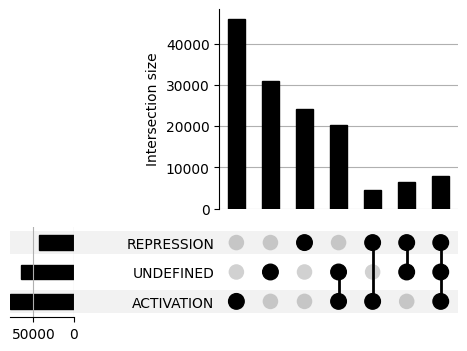

<h3>Table S1</h3>

,Counts
ACTIVATION,"46,040 (32.84%)"
REPRESSION,"24,051 (17.16%)"
UNDEFINED,"30,883 (22.03%)"
"ACTIVATION,REPRESSION","4,492 (3.20%)"
"ACTIVATION,UNDEFINED","20,240 (14.44%)"
"REPRESSION,UNDEFINED","6,551 (4.67%)"
"ACTIVATION,REPRESSION,UNDEFINED","7,918 (5.65%)"
1 MoR,"100,974 (72.03%)"
2 MoR,"31,283 (22.32%)"
3 MoR,"7,918 (5.65%)"


In [15]:
# FIGURE 2 & TABLE S1
def figure_2(df):
    # 1. Get the sets of TRIs for each MoR

    # Create a set of TRIs for each MoR
    A_set = set(df[df["MoR"] == 'ACTIVATION']['TRI Id'])
    R_set = set(df[df["MoR"] == 'REPRESSION']['TRI Id'])
    U_set = set(df[df["MoR"] == 'UNDEFINED']['TRI Id'])
    # 2. Get the union of these sets
    MoR_listoflists = [
        ['ACTIVATION'], ['REPRESSION'], ['UNDEFINED'],
        ['ACTIVATION', 'REPRESSION'],
        ['ACTIVATION', 'UNDEFINED'],
        ['REPRESSION', 'UNDEFINED'],
        ['ACTIVATION', 'REPRESSION', 'UNDEFINED']
    ]
    MoR_counts = [
        len(A_set - R_set - U_set), 
        len(R_set - A_set - U_set), 
        len(U_set - R_set - A_set),
        len((A_set & R_set) - U_set),
        len((A_set & U_set) - R_set),
        len((U_set & R_set) - A_set),
        len(A_set & R_set & U_set),    
    ]

    # Ignore warnings for upsetplot: it has a lot (library seems like is not updated)
    warnings.filterwarnings('ignore')
    example = upsetplot.from_memberships(MoR_listoflists, data=MoR_counts)
    upsetplot.plot(example)  # doctest: +SKIP
    h3("Figure 2")
    # plt.title("")
    plt.show()
    warnings.filterwarnings('default')

    return MoR_counts, MoR_listoflists

def table_S1(MoR_counts, MoR_listoflists):
    h3("Table S1")
    MoR_counts_table = {}
    for label, count in zip(MoR_listoflists, MoR_counts):
        MoR_counts_table[",".join(label)] = count

    MoR_counts_table['1 MoR'] = sum([MoR_counts_table[MoR] for MoR in ['ACTIVATION', 'REPRESSION', 'UNDEFINED']])
    MoR_counts_table['2 MoR'] = sum([MoR_counts_table[MoR] for MoR in ['ACTIVATION,REPRESSION', 'ACTIVATION,UNDEFINED', 'REPRESSION,UNDEFINED']])
    MoR_counts_table['3 MoR'] = MoR_counts_table['ACTIVATION,REPRESSION,UNDEFINED']
    TOTAL = sum([MoR_counts_table[f'{n} MoR'] for n in range(1, 4)])

    for key, value in MoR_counts_table.items():
        MoR_counts_table[key] = f"{value:,} ({value / TOTAL:.2%})"

    display(pd.DataFrame.from_dict(MoR_counts_table, orient='index', columns=['Counts']))

MoR_counts, MoR_listoflists = figure_2(dbTF_df)
table_S1(MoR_counts, MoR_listoflists)

24374 (2.93%) sentences are not considered in the analysis as their TF/TG is mapped to +1 ID
There are 0 human TFs and 820 human TGs in ExTRI2 that are not found in the all_human_genes df.
There are 830 human genes in ExTRI2 that are not found in the all_human_genes df (thus, outdated IDs)
They appear in 2608 rows, which are excluded from the TG distribution analysis, but kept for the rest of analysis.


Number of genes retrieved by category, considering direct human, and mouse/rat orthologs

,human,orthologs,unique,orth.unique,% uniq.,% orth.uniq.
Total,286690,421395,10125,11856,5.3%,10.6%
PROTEIN_CODING,276915,400707,9140,10138,44.4%,49.2%
ncRNA,8107,8531,807,684,3.7%,3.1%
PSEUDO,820,23,107,11,0.6%,0.1%
OTHER,728,0,37,0,4.4%,0.0%
snoRNA,21,9,10,7,0.8%,0.6%
tRNA,43,0,8,0,1.2%,0.0%
snRNA,30,22,7,5,4.2%,3.0%
BIOLOGICAL_REGION,15,0,6,0,0.0%,0.0%
rRNA,1,0,1,0,0.1%,0.0%


<span style='color:red'>There are 2 dbTFs that are non considered to be protein-coding, but are kept in the analysis.

,NCBI GeneID,Symbol,Gene Type,Taxonomic Name,Description
11907,100288711,DUX4L9,PSEUDO,Homo sapiens,double homeobox ...
17113,58160,NFE4,ncRNA,Homo sapiens,"nuclear factor, ..."


Number of retrieved human dbTFs

,unique,%
all considered,1788,100.0%
retrieved directly,1260,70.5%
retrieved (including orthologs),1321,73.9%


<h3>Figure 3</h3>

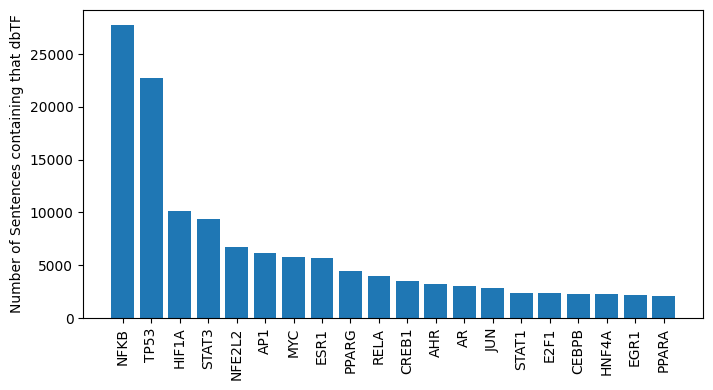

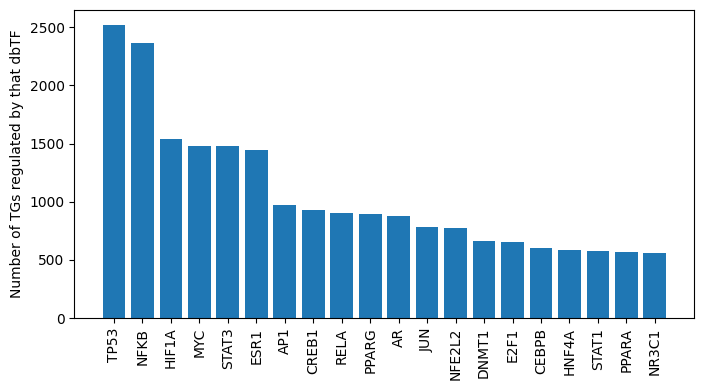

In [16]:
def load_all_human_genes():
    # Load all human TGs
    # downloaded from: https://www.ncbi.nlm.nih.gov/datasets/gene/taxon/9606/
    all_human_genes = pd.read_csv(config['all_human_TGs_p'], sep='\t', header=0, dtype=str)
    all_human_genes = all_human_genes[['NCBI GeneID', 'Symbol', 'Gene Type', 'Taxonomic Name', 'Description']]
    all_human_genes.loc[all_human_genes['Gene Type'].isna(), 'Gene Type'] = 'nan'

    # Add AP1 and NFKB complexes
    all_human_genes = pd.concat([all_human_genes, pd.DataFrame({
        'NCBI GeneID': ['Complex:AP1', 'Complex:NFKB'], 
        'Symbol': ['AP1', 'NFKB'],
        'Description': ['', ''],
        'Taxonomic Name': ['Homo sapiens', 'Homo sapiens'],
        'Gene Type': ['PROTEIN_CODING', 'PROTEIN_CODING'],
        })], ignore_index=True)
    
    # Ensure the data is expected: all human, no duplicate IDs
    assert all_human_genes['Taxonomic Name'].nunique() == 1
    assert all_human_genes['Taxonomic Name'].unique()[0] == 'Homo sapiens'
    assert (all_human_genes['NCBI GeneID'].duplicated()).sum() == 0 

    return all_human_genes

def display_TG_distribution(dbTF_df: pd.DataFrame, all_human_genes: pd.DataFrame) -> None:
    '''Display how many TGs we have retrieved'''

    # Get human TGs
    human_dbTF_df = dbTF_df[(dbTF_df['TG TaxID'] == '9606')] 

    m_TG_id = human_dbTF_df['TG Id'].isin(all_human_genes['NCBI GeneID'])
    print(f"There are {len(human_dbTF_df[~m_TG_id]['TG Id'].unique())} human genes in ExTRI2 that are not found in the all_human_genes df (thus, outdated IDs)")
    print(f"They appear in {(~m_TG_id).sum()} rows, which are excluded from the TG distribution analysis, but kept for the rest of analysis.")
    human_dbTF_df = human_dbTF_df[m_TG_id]

    # Initialise dict    
    TG_types = {}
    TG_types['Total'] = {
        'human': len(human_dbTF_df),
        'orthologs': len(dbTF_df),
        'unique': len(human_dbTF_df['TG Id'].unique()),
        'orth.unique': len(dbTF_df['TG_human_Id'].unique()),
        '% uniq.': f"{len(human_dbTF_df['TG Id'].unique()) / len(all_human_genes):.1%}",
        '% orth.uniq.': f"{len(dbTF_df['TG Id'].unique()) / len(all_human_genes):.1%}"
    }

    # Fill in dict
    for gene_type in all_human_genes['Gene Type'].unique():
        human_genes_of_gene_type = all_human_genes[all_human_genes['Gene Type'] == gene_type]['NCBI GeneID']

        human_sents = human_dbTF_df[human_dbTF_df['TG Id'].isin(human_genes_of_gene_type)]
        ortholog_sents = dbTF_df[dbTF_df['TG_human_Id'].isin(human_genes_of_gene_type)]
        TG_types[gene_type] = {
            'human': len(human_sents),
            'orthologs': len(ortholog_sents),
            'unique': len(human_sents['TG Id'].unique()),
            'orth.unique': len(ortholog_sents['TG_human_Id'].unique()),
        }
        TG_types[gene_type]['% uniq.']      = f"{TG_types[gene_type]['unique'] / len(human_genes_of_gene_type):.1%}"
        TG_types[gene_type]['% orth.uniq.'] = f"{TG_types[gene_type]['orth.unique'] / len(human_genes_of_gene_type):.1%}"


    # Convert to dataframe & display
    md("Number of genes retrieved by category, considering direct human, and mouse/rat orthologs")
    display(pd.DataFrame.from_dict(TG_types, orient='index').sort_values(by='unique', ascending=False))

def display_TF_distribution(dbTF_df: pd.DataFrame, all_human_genes: pd.DataFrame, dbTFs_set: set) -> None:

    human_dbTF_df = dbTF_df[(dbTF_df['TF TaxID'] == '9606')] 

    # Get all retrieved human dbTFs
    retrieved_TF_IDs = set(human_dbTF_df['TF Id'])

    # Ensure retrieved dbTFs are in the original list of dbTFs
    assert retrieved_TF_IDs.issubset(dbTFs_set), "Some dbTFs are not part of the original dbTFs list: {}".format(retrieved_TF_IDs - dbTFs_set)

    # Ensure they are all in the list of human genes
    assert retrieved_TF_IDs.issubset(set(all_human_genes['NCBI GeneID'])), "Some dbTFs are not part of the NCBI df"

    # Check if they are all protein-coding genes
    non_protein_coding_dbTFs = retrieved_TF_IDs - set(all_human_genes[all_human_genes['Gene Type'] == 'PROTEIN_CODING']['NCBI GeneID'])
    md(f"<span style='color:red'>There are {len(non_protein_coding_dbTFs)} dbTFs that are non considered to be protein-coding, but are kept in the analysis.")
    display(all_human_genes[all_human_genes['NCBI GeneID'].isin(non_protein_coding_dbTFs)])

    # Get the set of human dbTFs
    human_dbTFs_set = dbTFs_set.intersection(set(all_human_genes['NCBI GeneID']))

    # Prepare the dataframe to display, with counts and percentages
    human_dbTF_summary = {
        category: {
            "unique": count,
            "%": f"{count / len(human_dbTFs_set):.1%}"
        }
        for category, count in {
            'all considered': len(human_dbTFs_set),
            'retrieved directly': len(human_dbTF_df['TF Id'].unique()),
            'retrieved (including orthologs)': len(dbTF_df[~dbTF_df['TF_human_Id'].str.contains(';')]['TF_human_Id'].unique())
        }.items()
    }

    md("Number of retrieved human dbTFs")
    display(pd.DataFrame.from_dict(human_dbTF_summary, orient='index'))

def figure_3(human_dbTF_df):
    '''Plot the most common dbTFs'''

    h3("Figure 3")

    # Plot the most common dbTFs
    def plot_counts(df, ylabel):
        counts = df['TF Symbol'].value_counts()
        plt.figure(figsize=(8,4))
        plt.bar(counts[:20].index, counts[:20])
        plt.xticks(rotation='vertical')
        plt.ylabel(ylabel)

    # Plot dbTFs that appear in most sentences
    plot_counts(human_dbTF_df, "Number of Sentences containing that dbTF")
    
    # Plot dbTFs that are associated with the most TGs
    unique_TRIs = human_dbTF_df.drop_duplicates(subset='TRI Id', keep='first')
    plot_counts(unique_TRIs, "Number of TGs regulated by that dbTF")
    plt.show()    

def human_TF_TG_analysis(ExTRI2_df: pd.DataFrame, TFs_df: pd.DataFrame) -> None:
    '''Check the category of the found TGs'''

    # Load dataframe of all human genes
    all_human_genes = load_all_human_genes()

    # Show how many sentences have multiple mappings
    multiple_mapped = ((ExTRI2_df['TF Id'].str.contains(';')) | (ExTRI2_df['TG Id'].str.contains(';'))).sum()
    print(f"{multiple_mapped} ({multiple_mapped / len(ExTRI2_df):.2%}) sentences are not considered in the analysis as their TF/TG is mapped to +1 ID")

    # Filter ExTRI2 by only those containing human dbTFs (ignore those mapped to +1 ids)
    dbTF_df = ExTRI2_df[ExTRI2_df['TF_type'] == 'dbTF']
    human_dbTF_df = dbTF_df[(dbTF_df['TG TaxID'] == '9606') & (dbTF_df['TF TaxID'] == '9606')] 

    # Discard human TGs that are not found in the NCBI human genes df
    m_TF_id = human_dbTF_df['TF Id'].isin(all_human_genes['NCBI GeneID'])
    not_found_human_TF = human_dbTF_df[~m_TF_id]['TF Id'].unique()

    m_TG_id = human_dbTF_df['TG Id'].isin(all_human_genes['NCBI GeneID'])
    not_found_human_TG = human_dbTF_df[~m_TG_id]['TG Id'].unique()

    print(f"There are {len(not_found_human_TF)} human TFs and {len(not_found_human_TG)} human TGs in ExTRI2 that are not found in the all_human_genes df.")

    # Get set of all considered dbTFs
    dbTFs_set = set(TFs_df[TFs_df['updated TF type'] == 'dbTF']['Gene ID']) | {'Complex:NFKB', 'Complex:AP1'}

    # Show how many TGs and TFs we've obtained
    display_TG_distribution(dbTF_df, all_human_genes)
    display_TF_distribution(dbTF_df, all_human_genes, dbTFs_set)

    # Plot counts
    figure_3(human_dbTF_df)

    return

human_TF_TG_analysis(ExTRI2_df, TFs_df)

## Supp. File. Post-processing

**Post-processing and normalization scripts** in [postprocessing.py](../scripts/postprocessing/postprocessing.py) and [postprocessing_checkings.ipynb](../scripts/postprocessing/postprocessing_checkings.ipynb)
